In [1]:
from pathlib import Path
import webbrowser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from evolution.utils import process_config
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs, id_to_name, name_to_id
from enroadspy.generate_url import actions_to_url

In [2]:
results_dir = Path("results/actions")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

config = process_config(config)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

99 {'Action magnitude': True, 'Actions taken': True, 'Temperature change from 1850': True} 129 0


In [3]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [4]:
def filter_actions_dict(actions_dict: dict):
    input_specs = load_input_specs()
    filtered = {}
    for action in actions_dict:
        default = input_specs[input_specs["id"] == action]["defaultValue"].values[0]
        if actions_dict[action] != default:
            filtered[action] = actions_dict[action]
    return filtered

100
{'Source tax oil boe': 1.0, 'Annual improvement to energy efficiency of new capital stationary': 1.0, 'Carbon tax time to achieve initial target': 0.86, 'Apply carbon tax to biofuels': 0.82, 'Target change other GHGs leakage and waste': 0.79, 'Carbon tax phase 3 start': 0.78, 'Carbon tax final target': 0.77, 'Target future percent animal product': 0.61, 'Source tax gas MCF': 0.58, 'Crop feedstock tax boe': 0.56, 'Land CDR percent of reference': 0.56, 'Deforestation slider setting': 0.56, 'Carbon tax time to achieve final target': 0.54, 'Target change in other GHGs for ag': 0.54, 'Years to secure land for afforestation': 0.54, 'Cap fuel powered shipping and aviation transport': 0.51, 'Source tax stop time nuclear': 0.48, 'Years to plant land committed to afforestation': 0.48, 'Time to achieve electrification target transport road and rail': 0.44, 'Wood feedstock tax boe': 0.43, 'Time to achieve electrification target stationary': 0.42, 'Time to achieve ag practice targets': 0.42, 'T

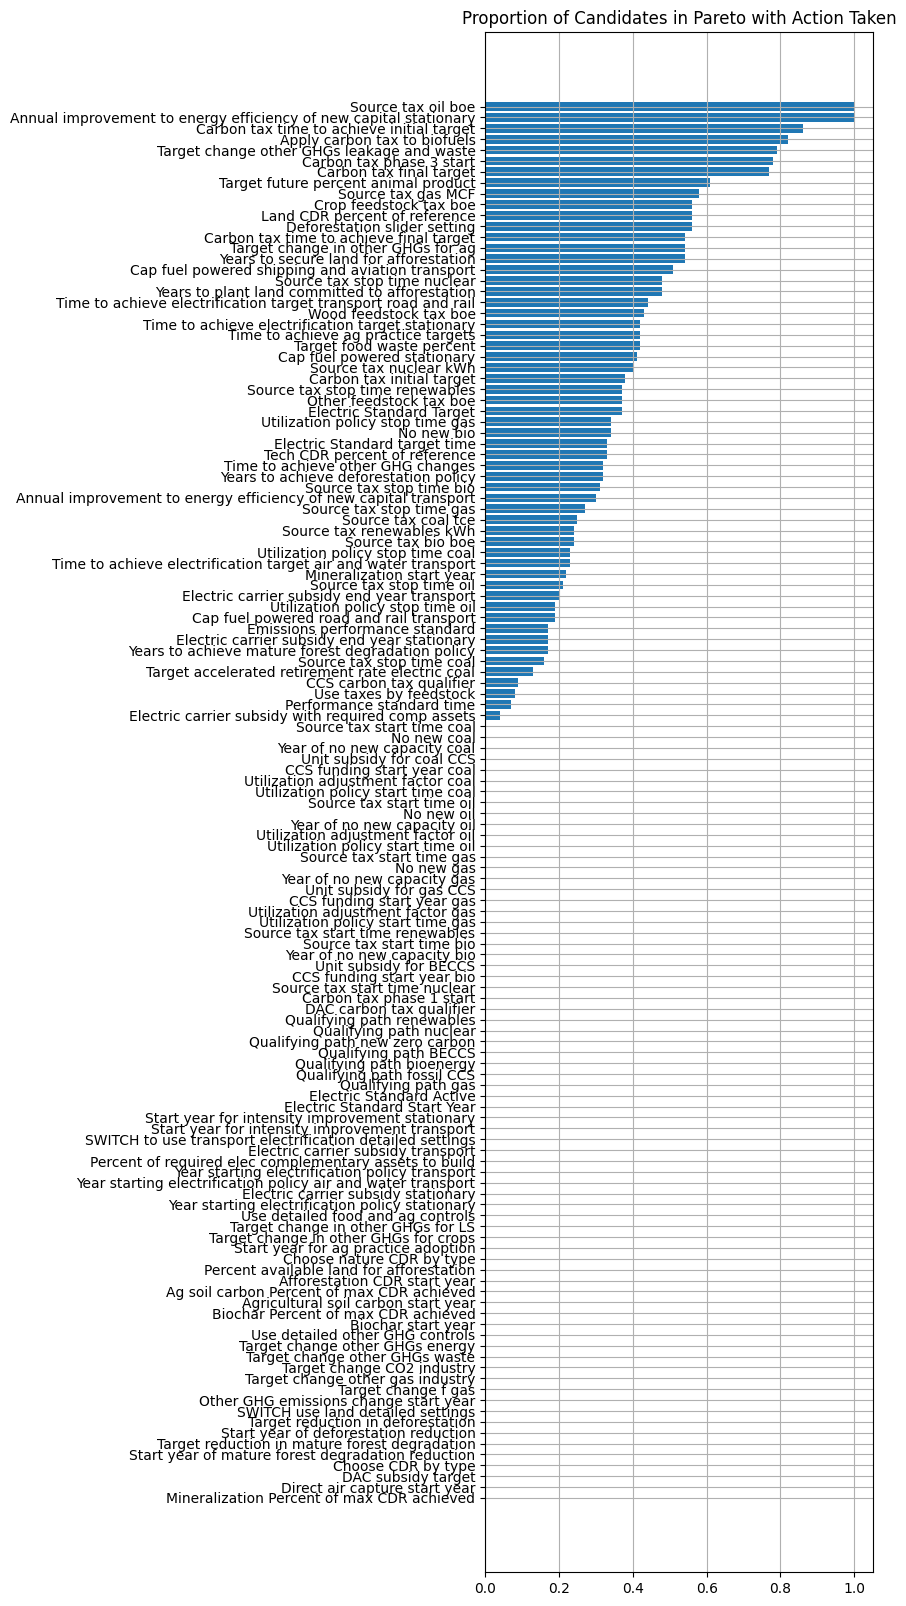

In [5]:
def plot_actions_taken(gen: int, magnitude=False):
    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    pareto_len = len(gen_df)
    print(pareto_len)
    actions_count = {action: 0 for action in actions}
    for cand_id in gen_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        for action in context_actions_dict:
            row = input_specs[input_specs["id"] == action].iloc[0]
            default_value = row["defaultValue"]
            if action not in context and context_actions_dict[action] != default_value:
                if not magnitude:
                    actions_count[action] += 1
                else:
                    min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
                    max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]
                    if min_value == max_value:
                        continue
                    norm = (context_actions_dict[action] - min_value) / (max_value - min_value)
                    default_norm = (default_value - min_value) / (max_value - min_value)
                    actions_count[action] += abs(norm - default_norm)

    # Switch to nice name, normalize values
    actions_count = {action: count / pareto_len for action, count in actions_count.items()}
    actions_count = dict(sorted(actions_count.items(), key=lambda item: item[1], reverse=True))
    pretty_actions_count = {id_to_name(action, input_specs): count for action, count in actions_count.items()}

    print(pretty_actions_count)
    fig, ax = plt.subplots(figsize=(5, 20))
    ax.barh(pretty_actions_count.keys(), pretty_actions_count.values())
    ax.set_title("Proportion of Candidates in Pareto with Action Taken")
    ax.grid()
    ax.invert_yaxis()
    plt.show()

    return actions_count

actions_count = plot_actions_taken(gens, magnitude=False)

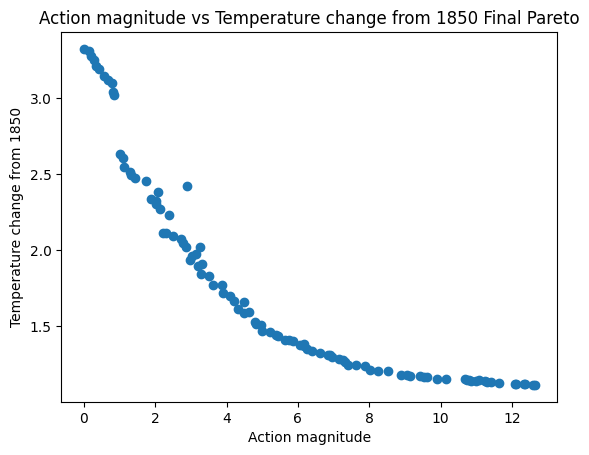

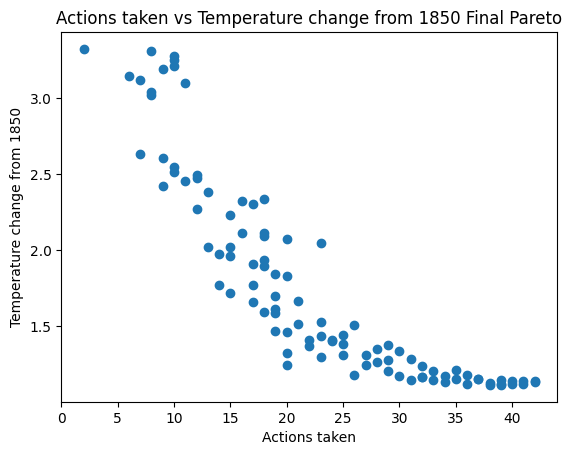

In [6]:
def plot_pareto(outcome1, outcome2, gen, colored_ids=[]):

    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    gen_df["color"] = gen

    plt.scatter(gen_df[outcome1], gen_df[outcome2])

    colors = ["pink", "lightgreen"]
    for colored_id, color in zip(colored_ids, colors):
        colored_df = gen_df[gen_df["cand_id"] == colored_id]
        plt.scatter(colored_df[outcome1], colored_df[outcome2], color=color)

    title = f"{outcome1} vs {outcome2} Final Pareto"
    plt.title(title)
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_pareto(outcome_keys[0], outcome_keys[2], gens)
plot_pareto(outcome_keys[1], outcome_keys[2], gens)

   cand_id  Temperature change from 1850  Actions taken  Action magnitude
0      1_2                       3.32279            2.0      1.748403e-08
86   94_22                       3.30978            8.0      1.362702e-01
84   95_36                       3.27813           10.0      2.116157e-01
83   75_89                       3.25051           10.0      2.921336e-01
33   73_43                       3.21133           10.0      3.399544e-01
16   85_55                       3.19393            9.0      4.266327e-01
6    92_23                       3.14510            6.0      5.579031e-01
25   47_16                       3.11849            7.0      6.784457e-01
15   80_66                       3.09927           11.0      7.854187e-01
21   60_99                       3.03808            8.0      8.273047e-01
5    83_75                       3.01793            8.0      8.520176e-01
4    50_12                       2.63444            7.0      1.004892e+00
55   88_99                       2.605

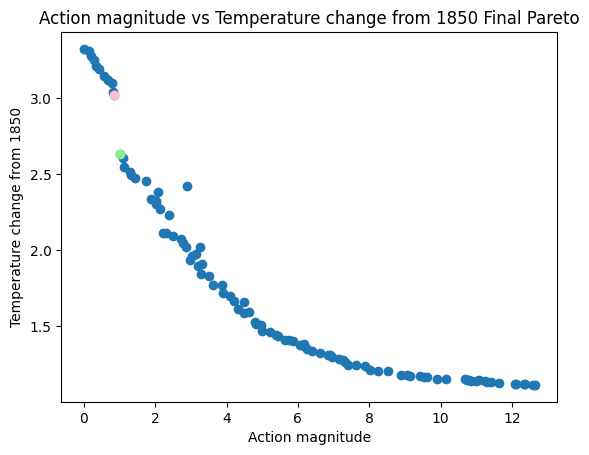

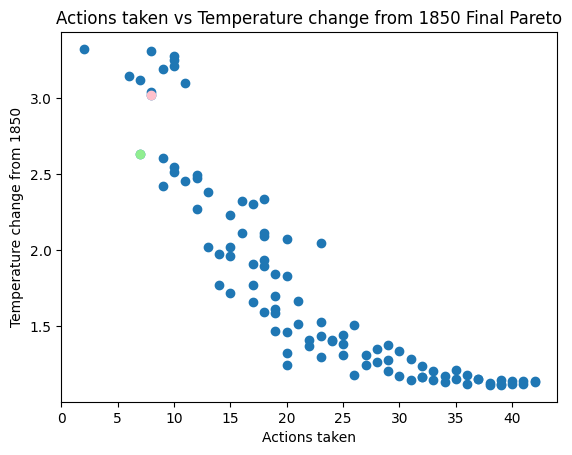

In [9]:
pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
pareto_df = pareto_df[pareto_df["rank"] == 1]
pareto_df = pareto_df.sort_values(by=[outcome_keys[2], outcome_keys[1], outcome_keys[0]], ascending=False)

print(pareto_df[["cand_id", outcome_keys[2], outcome_keys[1], outcome_keys[0]]].head(20))
special = ["83_75", "50_12"]
plot_pareto(outcome_keys[0], outcome_keys[2], gens, special)
plot_pareto(outcome_keys[1], outcome_keys[2], gens, special)

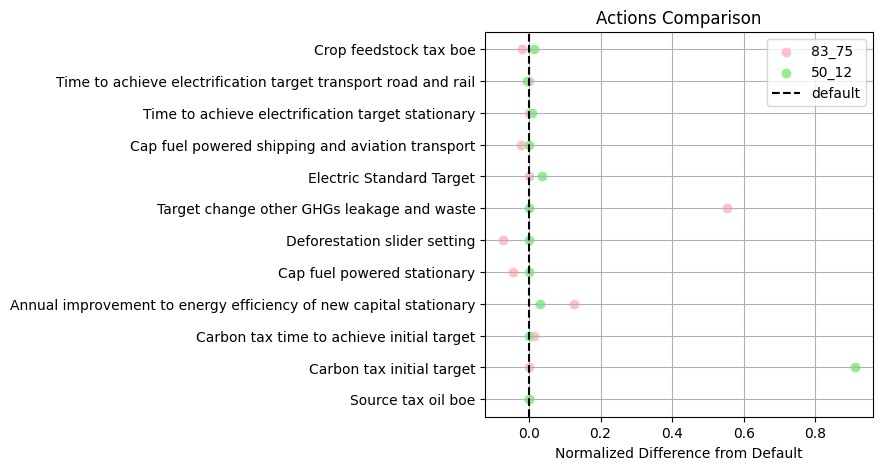

Bad pipe message: %s [b'\xc7$P\x8a\xb2\x11\xd7\xf2~\xa2\x16\xa8\xd3\xcf\xbb}\xa5\xb6\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00']
Bad pipe message: %s [b'\x00g\xd2G\x0cn\\\xc6\xb4\x9c\xdet']
Bad pipe message: %s [b'`A\x9dq\x1b\xe0Y\x13\xe2\x99?\x10*\x07\xcb\x7f\x83\x08\x00\x01|\x00\x00\x00\x01']
Bad pipe message: %s [b'\n\x00\x0b\x00\x0c\x00\r\x00']
Bad pipe message: %s [b'\xab\x92?\xfa\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009']
Bad pipe message: %s [b'\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15']


In [ ]:
def compare_actions(cand_1, cand_2):
    [ca_1], _, _ = experimenter.get_candidate_results(cand_1)
    [ca_2], _, _ = experimenter.get_candidate_results(cand_2)

    total_actions = list(set(ca_1.keys()).union(set(ca_2.keys())))

    all_actions = []
    norm1s = []
    norm2s = []
    defaults = []
    mins = []
    maxes = []

    for action in total_actions:
        row = input_specs[input_specs["id"] == action].iloc[0]
        default_value = row["defaultValue"]
        min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
        max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]

        if ca_1[action] == default_value and ca_2[action] == default_value:
            continue

        if min_value == max_value:
            norm_1 = 1
            norm_2 = 1
            norm_default = 1

        else:
            norm_default = (default_value - min_value) / (max_value - min_value)
            norm_1 = (ca_1[action] - min_value) / (max_value - min_value)
            norm_2 = (ca_2[action] - min_value) / (max_value - min_value)

            diff_1 = norm_1 - norm_default
            diff_2 = norm_2 - norm_default

        norm1s.append(diff_1)
        norm2s.append(diff_2)
        defaults.append(norm_default)
        mins.append(min_value)
        maxes.append(max_value)
        all_actions.append(action)

    df = pd.DataFrame({"action": all_actions,
                       "norm1": norm1s,
                       "norm2": norm2s,
                       "default": defaults,
                       "min": mins,
                       "max": maxes})
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(df["norm1"], range(len(df)), label=cand_1, color="pink")
    ax.scatter(df["norm2"], range(len(df)), label=cand_2, color="lightgreen")
    ax.axvline(x=0, color="black", linestyle="--", label="default")

    ax.set_xlabel("Normalized Difference from Default")
    ax.set_yticks(range(len(df)), df["action"].apply(lambda x: id_to_name(x, input_specs)))
    ax.set_title("Actions Comparison")
    ax.grid()
    ax.legend()

    plt.show()

compare_actions(*special)

In [11]:
def print_actions_dict(cand_id):
    [context_actions_dict], [outcomes_df], _ = experimenter.get_candidate_results(cand_id)
    true_ca_dict = {}
    for action in context_actions_dict:
        default_value = input_specs[input_specs["id"] == action]["defaultValue"].values[0]
        if context_actions_dict[action] != default_value:
            true_ca_dict[action] = context_actions_dict[action]
    print(true_ca_dict)

In [12]:
for cand_id in special:
    print_actions_dict(cand_id)

{7: 9.5367431640625e-07, 293: -0.9365711212158203, 41: 11.3856840133667, 47: 1.9534201622009277, 258: 97.67850494384766, 55: 95.46411895751953, 61: 55.24197769165039, 57: -0.7999839782714844}
{7: 9.5367431640625e-07, 293: 0.7127761840820312, 39: 232.71246337890625, 247: 76.435546875, 47: 1.3904695510864258, 261: 29.833768844604492, 260: 30.31987762451172}


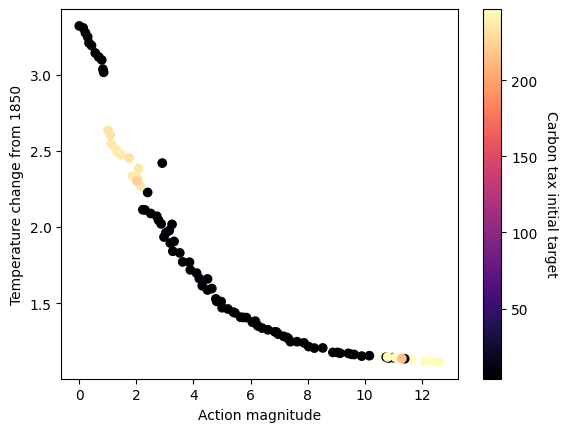

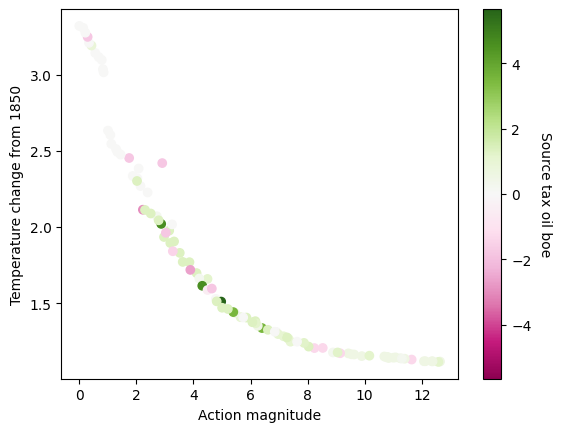

In [13]:
def color_pareto_by_action(action: str, outcome_1: str, outcome_2: str):
    pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
    pareto_df = pareto_df[pareto_df["rank"] == 1]

    action = name_to_id(action, input_specs)

    action_vals = []
    for cand_id in pareto_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        action_vals.append(context_actions_dict[action])
    
    pareto_df["action"] = action_vals

    fig, ax = plt.subplots()
    min_val = min(action_vals)
    max_val = max(action_vals)
    if min_val < 0 and max_val > 0:
        cmap_params = {"cmap": "PiYG", "vmin": min(min_val, -max_val), "vmax": max(-min_val, max_val)}
    else:
        cmap_params = {"cmap": "magma"}
    scatter = ax.scatter(pareto_df[outcome_1], pareto_df[outcome_2], c=pareto_df["action"], **cmap_params)
    ax.set_xlabel(outcome_1)
    ax.set_ylabel(outcome_2)
    cbar = fig.colorbar(scatter)
    cbar.set_label(id_to_name(action, load_input_specs()), rotation=270, labelpad=15)
    plt.show()

color_pareto_by_action("Carbon tax initial target", outcome_keys[0], outcome_keys[2])
color_pareto_by_action("Source tax oil boe", outcome_keys[0], outcome_keys[2])

In [14]:
[context_actions_dict], _, _ = experimenter.get_candidate_results(pareto_df.sort_values(outcome_keys[2])["cand_id"].values[0])
print(filter_actions_dict(context_actions_dict))
if config["decomplexify"]:
    context_actions_dict = evaluator.decomplexify_actions_dict(context_actions_dict)
url = actions_to_url(context_actions_dict)
webbrowser.open(url)

{4: 9.581436157226562, 7: 1.1648197174072266, 9: 2091.321533203125, 10: -0.0001017451286315918, 207: 2099.861572265625, 18: 2098.066650390625, 23: 10.556724548339844, 25: 2097.59228515625, 313: 66.48103332519531, 292: -0.618865966796875, 293: -2.386280059814453, 30: -0.0010935589671134949, 32: 2076.11572265625, 39: 246.77493286132812, 41: 1.0, 42: 1193.129638671875, 43: 2025.0, 44: 9.076738357543945, 312: 1.0, 249: 16.684879302978516, 47: 3.6229214668273926, 50: 0.5540604591369629, 261: 31.13644790649414, 258: 91.75678253173828, 337: 2096.50927734375, 55: 86.9275894165039, 260: 26.24492835998535, 60: 98.44734954833984, 422: 27.06747817993164, 287: 10.0, 305: 15.558067321777344, 417: 100.0, 218: 10.06916332244873, 219: 1.0, 61: 99.72349548339844, 284: 28.1048583984375, 57: -10.0, 67: 94.08667755126953, 73: 2029.559814453125}


True

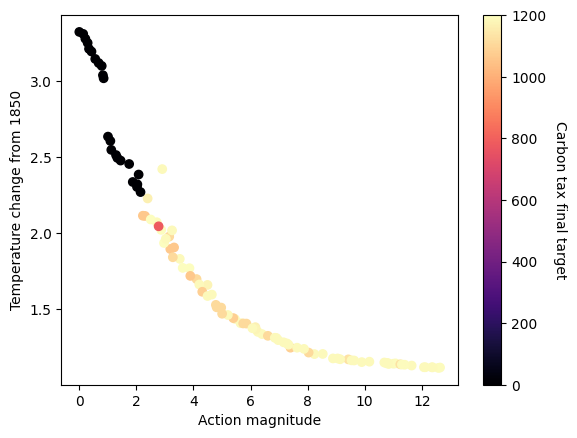

In [15]:
color_pareto_by_action("Carbon tax final target", outcome_keys[0], outcome_keys[2])